In [28]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./"), '..')))

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.fft import fft, ifft
import plot_settings as plot_settings
from scipy.signal import butter, sosfiltfilt

In [29]:
plot_settings.set_theme('dark')

# Loading data
data_file = "dati H1 32s progetto 3.txt"
template_file = "template.txt"
data = np.loadtxt(data_file)
template = np.loadtxt(template_file)

In [30]:
time = data[:, 0]
strain = data[:, 1]

# Computing data information
# Sampling
dt = time[1] - time[0]
# Sampling frequency
fs = 1 / dt
# Signal duration
T = len(time) * dt
# Resolution
df = 1 / T

template_length = len(template)

## Signal Analysis
Plotting informations about the signal to analyze it

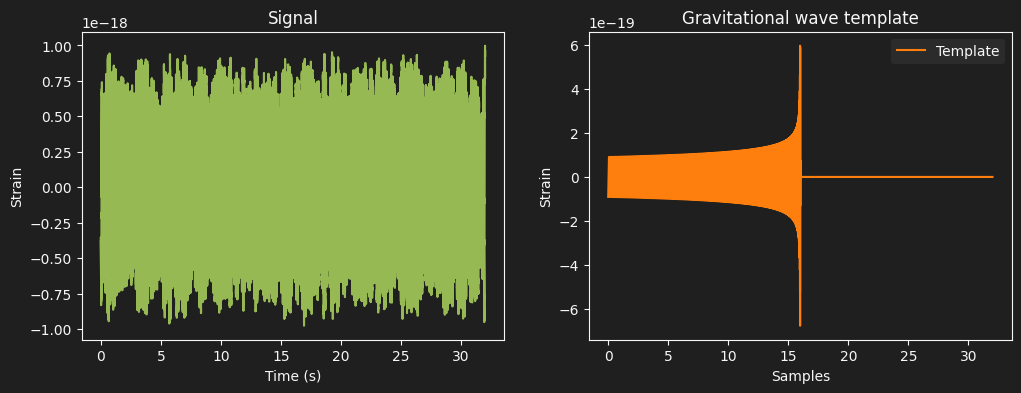

In [31]:

plot_settings.figure(figsize=(12,4))
plot_settings.subplot(1,2,1,"Time (s)","Strain")
plot_settings.title("Signal")

plt.plot((time-time[0]), strain, label="Strain", color=plot_settings.color(4))

plot_settings.subplot(1, 2, 2,"Samples", "Strain")
plot_settings.title("Gravitational wave template")
plt.plot(np.linspace(0,len(template)*dt,len(template)),template, label="Template", color=plot_settings.color(5))
plot_settings.legend()

(array([[1.66116596e-38, 2.26451044e-39, 1.39666056e-38, ...,
         1.38159171e-38, 1.48879469e-38, 1.17120485e-38],
        [1.17607913e-38, 6.80728336e-39, 9.56715350e-39, ...,
         1.18977827e-38, 1.34649220e-38, 1.35212061e-38],
        [1.96076800e-40, 1.72529790e-40, 1.35648885e-40, ...,
         1.56558700e-40, 2.27843386e-40, 3.04516096e-40],
        ...,
        [2.85864258e-45, 1.55016309e-44, 1.96578981e-45, ...,
         9.82895897e-45, 1.20242479e-44, 1.72352326e-44],
        [2.86742333e-45, 1.55233766e-44, 1.97436742e-45, ...,
         9.82665839e-45, 1.19513396e-44, 1.71696849e-44],
        [1.40495358e-45, 7.72304442e-45, 9.81707570e-46, ...,
         4.90030443e-45, 5.99847747e-45, 8.61376922e-45]]),
 array([   0.,   16.,   32.,   48.,   64.,   80.,   96.,  112.,  128.,
         144.,  160.,  176.,  192.,  208.,  224.,  240.,  256.,  272.,
         288.,  304.,  320.,  336.,  352.,  368.,  384.,  400.,  416.,
         432.,  448.,  464.,  480.,  496.,  512.,  5

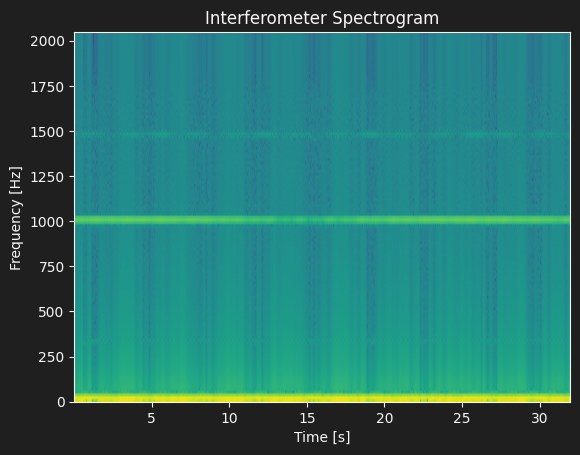

In [32]:
# Plotting spectogram
plot_settings.figure()
plot_settings.subplot(1,1,1,ylabel="Frequency [Hz]", xlabel="Time [s]")
plot_settings.title("Interferometer Spectrogram")
plt.specgram(strain, Fs= int(fs), NFFT=256, window=np.hamming(256))

In [33]:
# Stima del Power Spectral Density (PSD) usando Welch
frequencies, psd = welch(strain, fs=fs, nperseg=fs//2)
psd_interp = np.interp(np.fft.fftfreq(len(strain), d=dt), frequencies, psd)

# Stima del Power Spectral Density (PSD) usando Welch
frequencies_temp, psd_temp = welch(template, fs=fs, nperseg=fs//2)


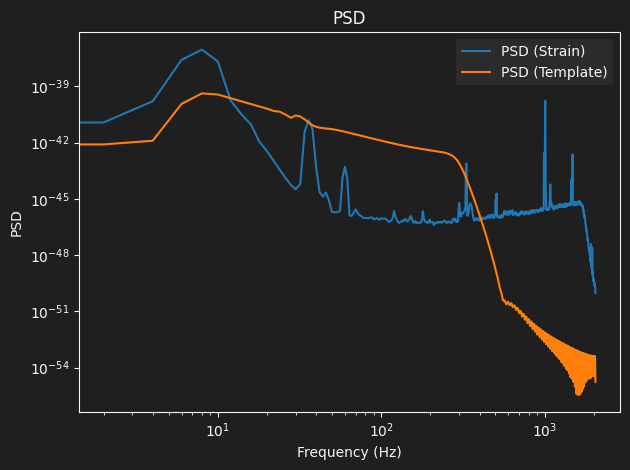

In [34]:

plot_settings.figure()
plot_settings.subplot(1,1,1,"Frequency (Hz)","PSD")
plot_settings.title("PSD")

plt.loglog(frequencies, psd, label="PSD (Strain)")
plt.loglog(frequencies_temp, psd_temp, label="PSD (Template)", color=plot_settings.color(5))

plot_settings.legend()
plt.tight_layout()
plt.show()

## Working on the signal
Filtering the signal based on the information previousely visualized to enhance the signal

In [35]:
# Keeping the frequencies where the signal 
# is stronger than the noise
lowcut = 30
highcut = 200
order = 4

# Using butterworth as a bandpass on
# both the strain and template
sos = butter(order, [lowcut, highcut], btype='bandpass', fs=fs, output='sos')
filtered_strain = sosfiltfilt(sos, strain)
filtered_template = sosfiltfilt(sos, template)

In [36]:
# Computing filtered strain and template psd using welch
frequencies_filtered, psd_filtered = welch(filtered_strain, fs=fs, nperseg=fs//2)
frequencies_filt_temp, psd_filt_temp = welch(filtered_template, fs=fs, nperseg=fs//2)

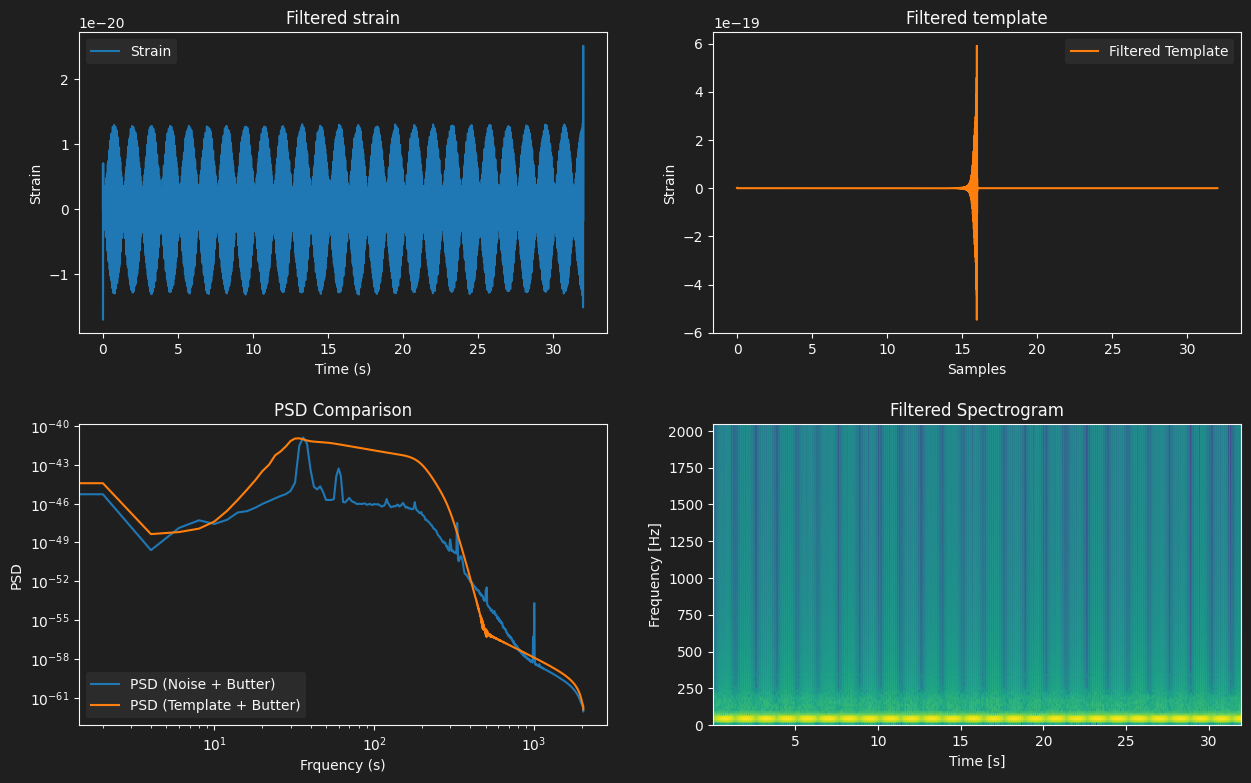

In [37]:
# Plotting results
plot_settings.figure(figsize=(15, 9))
plot_settings.subplot(2, 2, 1,"Time (s)", "Strain")
plot_settings.title("Filtered strain")
plt.plot(time-time[0], filtered_strain, label="Strain")
plot_settings.legend()

plot_settings.subplot(2, 2, 2,"Samples", "Strain")
plot_settings.title("Filtered template")
plt.plot(np.linspace(0,len(filtered_template)*dt,len(filtered_template)),filtered_template, label="Filtered Template", color=plot_settings.color(5))
plot_settings.legend()

plot_settings.subplot(2, 2, 3,"Frquency (s)", "PSD")
plot_settings.title("PSD Comparison")
plt.loglog(frequencies_filtered, psd_filtered, label="PSD (Noise + Butter)")
plt.loglog(frequencies_filt_temp, psd_filt_temp, label="PSD (Template + Butter)")
plot_settings.legend()

# Plotting spectogram
plot_settings.subplot(2,2,4,ylabel="Frequency [Hz]", xlabel="Time [s]")
plot_settings.title("Filtered Spectrogram")
plt.specgram(filtered_strain, Fs= int(fs), NFFT=256, window=np.hamming(256))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

## Computing SNR and finding its peak
This section will compute the SNR index based on the filtered signals and find its peak to find the best alignment for the template signal

In [38]:
# Computing filtered signals ffts
fft_filtered_strain = dt * fft(filtered_strain)
fft_template = dt * fft(filtered_template)
fft_template_conjugate = fft_template.conjugate() # template conjugate

# Computing template norm to normalize the template
# and its coniugate's fft
template_norm = np.divide(fft_template*fft_template_conjugate, psd_interp)
norm = sum(np.real(template_norm))
norm = norm*df

# Normalizing
template_fft_normalized = np.divide(fft_template,np.sqrt(norm))
template_fft_conjugate_normalized = np.divide(fft_template_conjugate,np.sqrt(norm))

integrand = np.divide(fft_filtered_strain*template_fft_conjugate_normalized,psd_interp)

# Using matched filter
snr_time_domain = np.abs(ifft(integrand)/dt)

# Identifying snr peak
peak_snr_idx = np.argmax(snr_time_domain)
peak_time = time[peak_snr_idx] - time[0] # Counting from 0
peak_snr_value = snr_time_domain[peak_snr_idx]

print(f"SNR peak time location [from 0]: {peak_time:.3f}")
print("SNR peak value:", peak_snr_value)

SNR peak time location [from 0]: 16.015
SNR peak value: 25.530522949556268


In [39]:
# This function is used to plot the peak
# vertical lign at a given location in time
def plot_peak(time):
    plt.axvline(time, color=plot_settings.color(1), linestyle='--', label="SNR Peak")

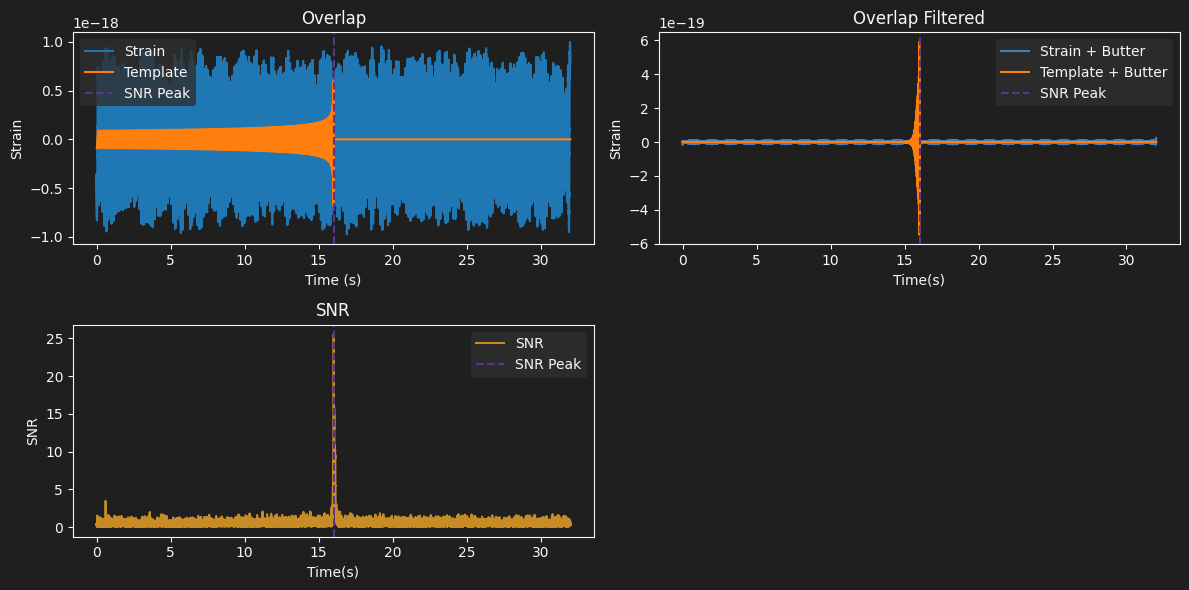

In [40]:

half_template = len(template) // 2
offset = peak_snr_idx - half_template

shifted_times = (time-time[0])
# Risultati e visualizzazione
plot_settings.figure(figsize=(12, 6))

# Normal strain and template overlap
plot_settings.subplot(2, 2, 1,"Time (s)", "Strain")
plot_settings.title("Overlap")
plt.plot(shifted_times, strain, label="Strain")
plt.plot(shifted_times + offset * dt,template, label="Template", color=plot_settings.color(5))
plot_peak(peak_time)
plot_settings.legend()

# Filtered strain and template overlap
plot_settings.subplot(2, 2, 2,"Time(s)", "Strain")
plot_settings.title("Overlap Filtered")
plt.plot(shifted_times, filtered_strain, label="Strain + Butter", color=plot_settings.color(3))
plt.plot(shifted_times + offset*dt,filtered_template, label="Template + Butter", color=plot_settings.color(5))
plot_peak(peak_time)
plot_settings.legend()

# SNR in time domain
plot_settings.subplot(2, 2, 3,"Time(s)", "SNR")
plt.plot(shifted_times, snr_time_domain, label="SNR", color=plot_settings.color(0))
plot_peak(peak_time)
plot_settings.title("SNR")
plot_settings.legend()

plt.tight_layout()
plt.show()
